#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. We will be analyzing the relationship between *Senators* and *Subjects* they are interested in. This type of social network is known as *affiliation* or *bipartite* networks.

###Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###We will be extracting following information from the data

- Senators presenting most bills
- Subjects on which most bills are presented.

###Data Source

For the project, we are analyzing affiliation between sponsors and subjects of bills within the U.S. Senate of the 114th Congress that met from January 3, 2015, to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject as `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

#Small subset of data
query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`")

smallSubset = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Small subset
subSetsenatorsList = smallSubset.senator.unique()
subSetsubjectList = smallSubset.subject.unique()

subSetsenatorsList = subSetsenatorsList.tolist()
subSetsubjectList = subSetsubjectList.tolist()

###Classification of bills sponsored by Senator based on subject.

In [3]:
#Weight shows number of bills presented on a subject by Senator
subjectInfo.sort_values(['weight'], ascending = False, inplace=True)
subjectInfo

senator                              subject  weight
710        Lisa Murkowski                               Energy      30
887        Orrin G. Hatch                             Taxation      23
204        Chuck Grassley                               Health      21
716        Lisa Murkowski   Public lands and natural resources      17
290          David Vitter                               Health      17
638            Jon Tester   Armed forces and national security      15
107          Bill Cassidy                               Health      15
645            Jon Tester                     Native Americans      14
280          David Vitter                             Commerce      13
1135        Sherrod Brown                               Health      13
859           Mike Rounds   Armed forces and national security      13
1090            Ron Wyden   Public lands and natural resources      13
199        Chuck Grassley            Crime and law enforcement      13
359      Edward J. Markey                               Energy      13
1093            Ron Wyden                             Taxation      12
761      Mark Steven Kirk   Armed forces and national security      12
465        Jeanne Shaheen   Armed forces and national security      12
626            John Thune                             Taxation      12
523           Jerry Moran   Armed forces and national security      11
769      Mark Steven Kirk                               Health      11
562         John Barrasso                     Native Americans      11
151    Charles E. Schumer            Crime and law enforcement      11
1050  Robert P. Jr. Casey                               Health      11
301           Dean Heller   Armed forces and national security      11
83     Benjamin L. Cardin                International affairs      11
1073          Ron Johnson   Government operations and politics      11
5              Al Franken                               Health      11
957    Richard Blumenthal   Armed forces and national security      10
872        Orrin G. Hatch            Crime and law enforcement      10
728           Marco Rubio                International affairs      10
...                   ...                                  ...     ...
623            John Thune                     Native Americans       1
629        Johnny Isakson         Economics and public finance       1
630        Johnny Isakson   Government operations and politics       1
572          John Boozman                               Energy       1
570          John Boozman              Arts, culture, religion       1
568          John Boozman                 Agriculture and food       1
546          Joe Donnelly                 Labor and employment       1
531           Jerry Moran                                  Law       1
533           Jerry Moran   Public lands and natural resources       1
534           Jerry Moran  Science, technology, communications       1
537           Jerry Moran          Water resources development       1
539          Joe Donnelly            Crime and law enforcement       1
540          Joe Donnelly                            Education       1
541          Joe Donnelly             Environmental protection       1
543          Joe Donnelly   Government operations and politics       1
544          Joe Donnelly                               Health       1
545          Joe Donnelly    Housing and community development       1
547          Joe Donnelly      Transportation and public works       1
566         John Barrasso      Transportation and public works       1
548       Joe Manchin III   Armed forces and national security       1
549       Joe Manchin III         Economics and public finance       1
551       Joe Manchin III         Finance and financial sector       1
552       Joe Manchin III   Government operations and politics       1
554       Joe Manchin III                 Labor and employment       1
555       Joe Manchin III   Public lands a

Lisa Murkowski is the Chairman of Committee on Energy and Natural Resources. Orrin G. Hatch is the Chairman of Committee on Finance.

###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a bill subject. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no connection between Senators. We can also notice there is no link between bill subjects.

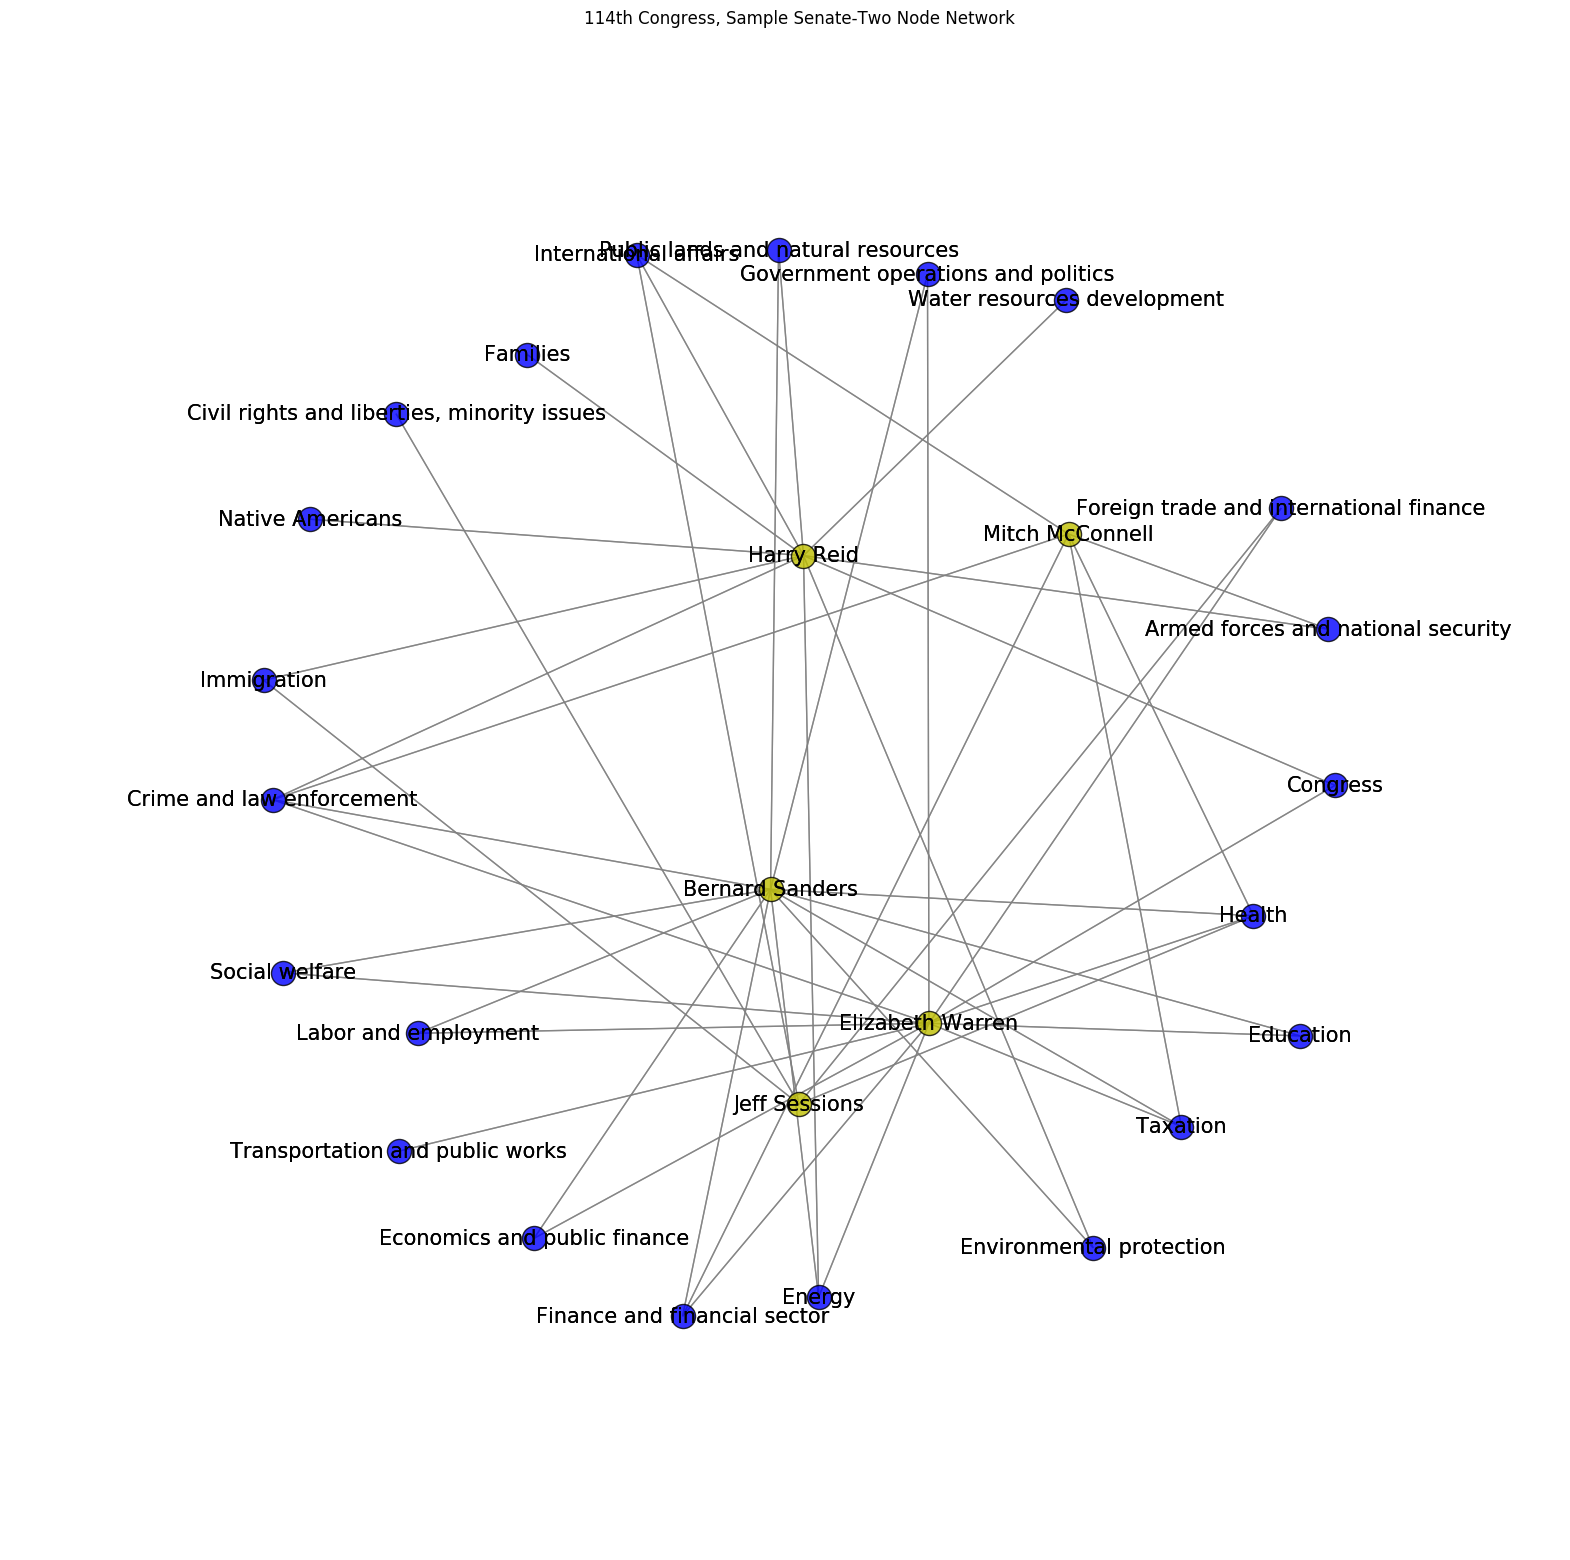

In [4]:
#Small subset data to show two-mode graph
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(subSetsenatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subSetsubjectList, bipartite=1)

for index, row in smallSubset.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.5, iterations=25)
nx.draw(B, nodelist = subSetsenatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subSetsubjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Sample Senate-Two Node Network')
plt.show()

Following is an entire two-mode graph showing a relationship between Senators and bill subjects. We will be working with the whole dataset for the rest of the project.

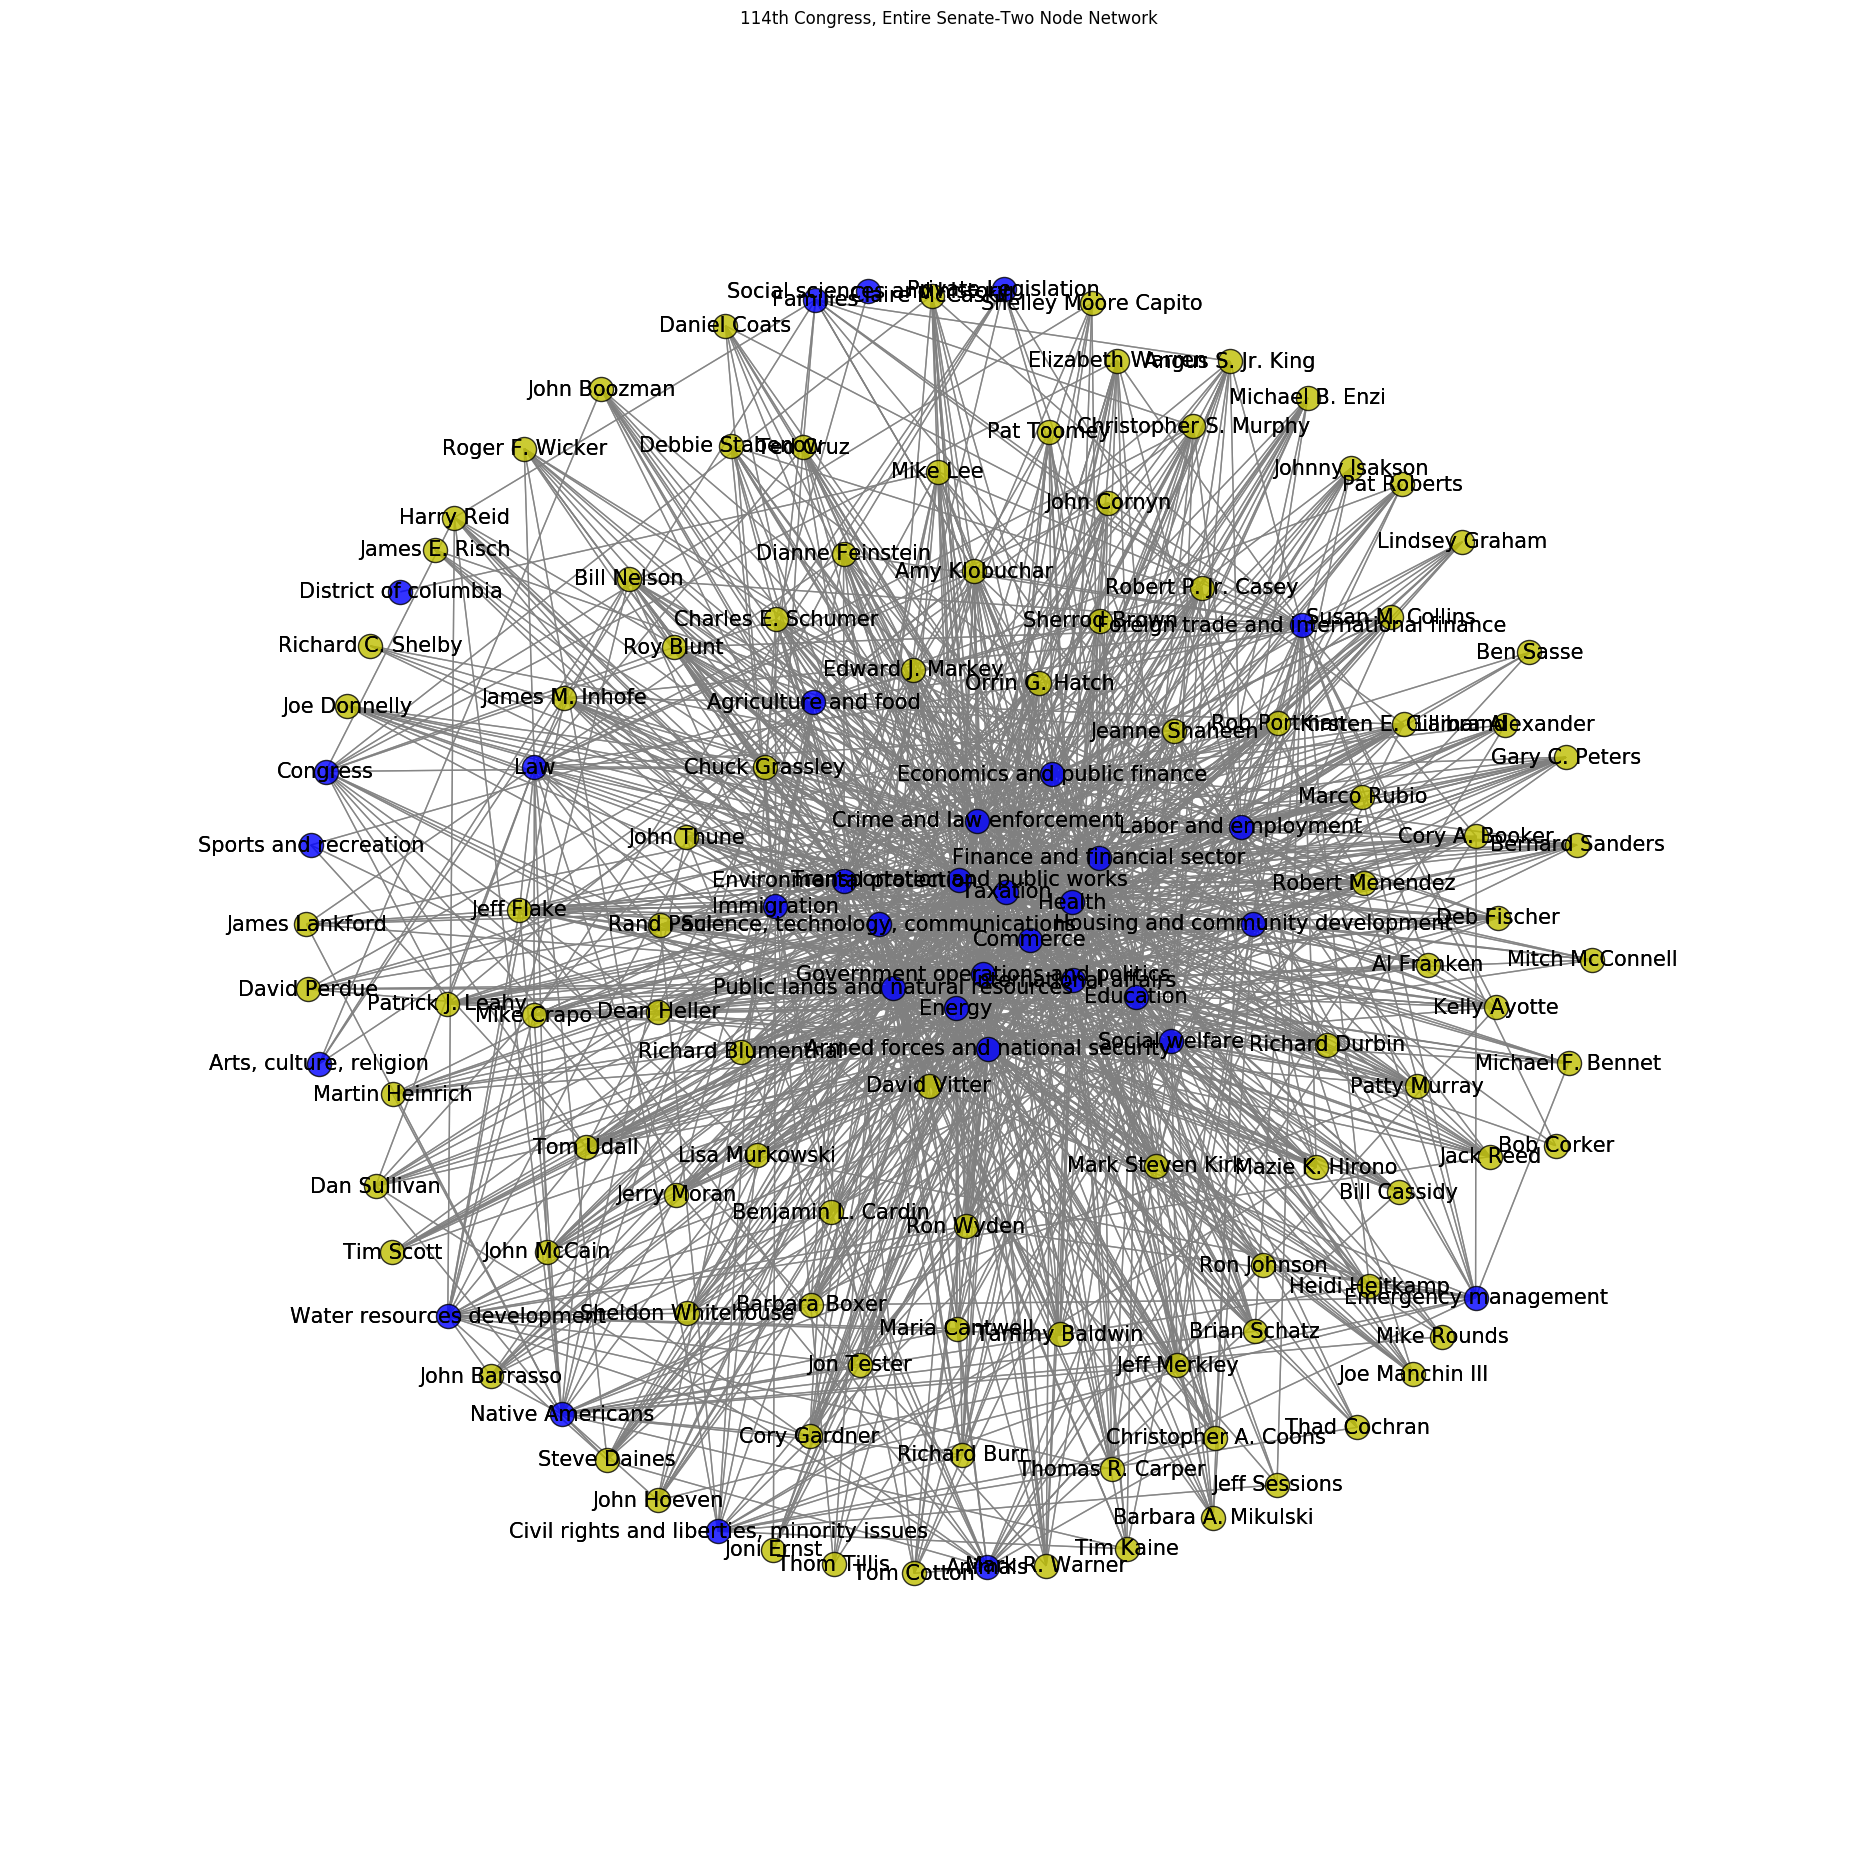

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(18, 18))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.3, iterations=75)
nx.draw(B, nodelist = senatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Entire Senate-Two Node Network')
plt.show()

Get information about node sets. There are 100 Senators and 34 bill subjects.

In [6]:
#Graph can be queried to get information about node sets
top_nodes, bottom_nodes = bipartite.sets(B)

#Total of 100 Senators
print (len(top_nodes))

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Subjects'])
df

34


Subjects
0                          Labor and employment
1           Science, technology, communications
2            Government operations and politics
3                                     Education
4                                      Taxation
5                         International affairs
6                                      Congress
7                                Social welfare
8                              Native Americans
9            Armed forces and national security
10                                          Law
11                                     Families
12                         District of columbia
13                      Arts, culture, religion
14                                       Energy
15                         Agriculture and food
16                        Sports and recreation
17                  Social sciences and history
18           Public lands and natural resources
19                         Emergency management
20                                     Commerce
21      Foreign trade and international finance
22                          Private Legislation
23  Civil rights and liberties, minority issues
24                    Crime and law enforcement
25                 Economics and public finance
26                                       Health
27              Transportation and public works
28                 Finance and financial sector
29                     Environmental protection
30                  Water resources development
31                                      Animals
32                                  Immigration
33            Housing and community development

In [7]:
#Total of 34 Bill Subjects
print (len(bottom_nodes))

#Bill Subjects
df = pd.DataFrame(list(bottom_nodes), columns=['Senators'])
df

100


Senators
0             Rob Portman
1               Tom Udall
2               Rand Paul
3             Thom Tillis
4            Patty Murray
5         Mitch McConnell
6          Maria Cantwell
7         James M. Inhofe
8          Cory A. Booker
9            David Vitter
10             John Thune
11            John Cornyn
12     Richard Blumenthal
13           Dan Sullivan
14        Robert Menendez
15             Tom Cotton
16               Mike Lee
17           Jeff Merkley
18        Bernard Sanders
19              Tim Scott
20             Jeff Flake
21      Angus S. Jr. King
22             Harry Reid
23  Christopher S. Murphy
24    Barbara A. Mikulski
25            Bill Nelson
26       Patrick J. Leahy
27              Jack Reed
28           Steve Daines
29            John McCain
..                    ...
70           Joe Donnelly
71      Richard C. Shelby
72       Susan M. Collins
73         Gary C. Peters
74         Mark R. Warner
75           John Boozman
76          Tammy Baldwin
77           Kelly Ayotte
78             Bob Corker
79  Kirsten E. Gillibrand
80         James E. Risch
81           Richard Burr
82           Bill Cassidy
83      Michael F. Bennet
84     Benjamin L. Cardin
85             Al Franken
86             Joni Ernst
87         Heidi Heitkamp
88            John Hoeven
89       Edward J. Markey
90       Mark Steven Kirk
91              Ben Sasse
92           Daniel Coats
93       Thomas R. Carper
94   Christopher A. Coons
95        Debbie Stabenow
96   Shelley Moore Capito
97    Robert P. Jr. Casey
98              Roy Blunt
99              Ron Wyden

[100 rows x 1 columns]

In [8]:
#Get total number of nodes in the graph (Senators + Bill Subjects)
bipartite.sets(B)
nx.number_of_nodes(B)

134

In [9]:
#Diameter of the graph. Total number of bill presented by Senators during 114th congress.
print(B.size())

1265


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 1 and bill subject bipartite value is 0
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

Node  bipartite
93                                    Al Franken          0
56                                 Amy Klobuchar          0
62                             Angus S. Jr. King          0
4                            Barbara A. Mikulski          0
106                                Barbara Boxer          0
24                                     Ben Sasse          0
113                           Benjamin L. Cardin          0
128                              Bernard Sanders          0
88                                  Bill Cassidy          0
89                                   Bill Nelson          0
83                                    Bob Corker          0
1                                   Brian Schatz          0
102                           Charles E. Schumer          0
115                         Christopher A. Coons          0
71                         Christopher S. Murphy          0
42                                Chuck Grassley          0
27                              Claire McCaskill          0
22                                Cory A. Booker          0
54                                  Cory Gardner          0
33                                  Dan Sullivan          0
111                                 Daniel Coats          0
120                                 David Perdue          0
23                                  David Vitter          0
107                                  Dean Heller          0
123                                  Deb Fischer          0
117                              Debbie Stabenow          0
13                              Dianne Feinstein          0
103                             Edward J. Markey          0
129                             Elizabeth Warren          0
50                                Gary C. Peters          0
..                                           ...        ...
51   Civil rights and liberties, minority issues          1
32                                      Commerce          1
58                                      Congress          1
118                    Crime and law enforcement          1
84                          District of columbia          1
122                 Economics and public finance          1
8                                      Education          1
96                          Emergency management          1
25                                        Energy          1
125                     Environmental protection          1
82                                      Families          1
95                  Finance and financial sector          1
105      Foreign trade and international finance          1
68            Government operations and politics          1
74                                        Health          1
36             Housing and community development          1
130                                  Immigration          1
43                         International affairs          1
63                          Labor and employment          1
81                                           Law          1
19                              Native Americans          1
47                           Private Legislation          1
94            Public lands and natural resources          1
67           Science, technology, communications          1
40                   Social sciences and history          1
75                                Social welfare          1
76                         Sports and recreation          1
9                                       Taxation          1
55               Transportation and public works          1
108                  Water resources development          1

[134 rows x 2 columns]

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric shows, bills sponsored by Senator Amy Klobuchar on subjects *Health* and *Science, technology, communications* make it to the floor faster compared to Senator Tom Cotton and Senator Tom Udall.

Example:
Minnesota Democratic Senator Amy Klobuchar has sponsored bills on subjects *Health* and *Science, technology, communications*. She and her staff have more experience than Arkansas Republican Senator Tom Cotton in getting these bills through committees and onto the Senate floor. If people of Arkansas want any legislation introduced related to *Health* and *Science, technology, communications* their chances of getting the bill onto the floor through Senator Amy Klobuchar are very high compared to   Senator Tom Cotton.

In [11]:
#Gives information about average shortest path between Senators and Subjects. 
#Every Senator has at least two subjects common with other Senators.
nx.average_shortest_path_length(B)

2.116934126360678

In [12]:
#Shortest path between Senators and bill subjects
#Value is close to average shortest path.
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 1)]
df2 = df[(df.bipartite == 0)]

cols = ['Senator', 'Subject', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Senator', 'Subject'], ascending = True, inplace=True)
ShortPath

Senator                Subject  ShortestPath
2444         Agriculture and food          Amy Klobuchar             1
2448         Agriculture and food      Angus S. Jr. King             1
2454         Agriculture and food  Christopher S. Murphy             1
2434         Agriculture and food         Chuck Grassley             1
2427         Agriculture and food           Dan Sullivan             1
2489         Agriculture and food           David Perdue             1
2419         Agriculture and food           David Vitter             1
2466         Agriculture and food        James M. Inhofe             1
2442         Agriculture and food         Jeanne Shaheen             1
2447         Agriculture and food             Jeff Flake             1
2450         Agriculture and food            Jerry Moran             1
2457         Agriculture and food           John Boozman             1
2471         Agriculture and food            John Hoeven             1
2476         Agriculture and food  Kirsten E. Gillibrand             1
2497         Agriculture and food         Lisa Murkowski             1
2438         Agriculture and food               Mike Lee             1
2451         Agriculture and food            Pat Roberts             1
2465         Agriculture and food       Patrick J. Leahy             1
2415         Agriculture and food           Patty Murray             1
2425         Agriculture and food     Richard Blumenthal             1
2429         Agriculture and food         Richard Durbin             1
2436         Agriculture and food        Robert Menendez             1
2493         Agriculture and food    Robert P. Jr. Casey             1
2428         Agriculture and food        Roger F. Wicker             1
2473         Agriculture and food            Ron Johnson             1
2455         Agriculture and food       Susan M. Collins             1
2413         Agriculture and food              Tom Udall             1
1383                      Animals     Benjamin L. Cardin             1
1363                      Animals           Bill Cassidy             1
1385                      Animals   Christopher A. Coons             1
...                           ...                    ...           ...
2952  Water resources development        Michael B. Enzi             3
2914  Water resources development      Michael F. Bennet             3
2938  Water resources development               Mike Lee             3
2902  Water resources development            Mike Rounds             3
2907  Water resources development        Mitch McConnell             3
2931  Water resources development         Orrin G. Hatch             3
2951  Water resources development            Pat Roberts             3
2945  Water resources development             Pat Toomey             3
2965  Water resources development       Patrick J. Leahy             3
2915  Water resources development           Patty Murray             3
2910  Water resources development              Rand Paul             3
2925  Water resources development     Richard Blumenthal             3
2962  Water resources development           Richard Burr             3
2953  Water resources development      Richard C. Shelby             3
2929  Water resources development         Richard Durbin             3
2900  Water resources development            Rob Portman             3
2936  Water resources development        Robert Menendez             3
2993  Water resources development    Robert P. Jr. Casey             3
2928  Water resources development        Roger F. Wicker             3
2973  Water resources development            Ron Johnson             3
2994  Water resources development              Roy Blunt             3
2992  Water resources development   Shelley Moore Capito             3
2905  Water resources development          Sherrod Brown             3
2955  Water resources development       Susan M. Collins             3
2935  Water resources development               Te

###Node centralities

We will be showing metrics

- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, *Health* and *Taxation* top the list in all three metrics. In other words, both subjects unite Senators closely than any other subject. Subject *District of Columbia* least popular among Senators.

In [13]:
#Closeness Betweenness Degrees centrality between Senetors and Subjects
close = nx.closeness_centrality(B)
between = nx.betweenness_centrality(B)
degree = nx.degree_centrality(B)
df1 = pd.DataFrame(list(close.items()), columns=['Node', 'Closeness'])
df2 = pd.DataFrame(list(between.items()), columns=['Node', 'Betweenness'])
df3 = pd.DataFrame(list(degree.items()), columns=['Node', 'Degrees'])
df = df1.join(df2.set_index('Node'), on='Node').join(df3.set_index('Node'), on='Node')
df.sort_values(['Closeness', 'Betweenness','Degrees'], ascending = False, inplace=True)
df

Node  Closeness  Betweenness  \
55                                        Health   0.692708     0.101990   
8                                       Taxation   0.651961     0.081904   
41            Public lands and natural resources   0.604545     0.064795   
68            Government operations and politics   0.599099     0.063533   
90            Armed forces and national security   0.588496     0.064645   
118                    Crime and law enforcement   0.545082     0.045923   
56               Transportation and public works   0.545082     0.042655   
7                                      Education   0.527778     0.035685   
22                                  David Vitter   0.523622     0.008982   
44                         International affairs   0.519531     0.046628   
125                 Finance and financial sector   0.515504     0.036473   
94                      Environmental protection   0.515504     0.033388   
57                                 Amy Klobuchar   0.515504     0.006491   
62                                    Jeff Flake   0.511538     0.006419   
6                                 Jeanne Shaheen   0.507634     0.006398   
38                                Orrin G. Hatch   0.507634     0.005318   
35                            Charles E. Schumer   0.503788     0.021357   
49                                      Mike Lee   0.503788     0.019391   
40                                     Tom Udall   0.503788     0.009767   
28                            Richard Blumenthal   0.503788     0.009606   
46                               Robert Menendez   0.503788     0.006964   
133                                    Ron Wyden   0.503788     0.005168   
33                                Richard Durbin   0.503788     0.004653   
0                                    Rob Portman   0.503788     0.004406   
54                              Mark Steven Kirk   0.503788     0.004089   
19                               James M. Inhofe   0.500000     0.008501   
88                                   Bill Nelson   0.500000     0.007933   
65                                    Mike Crapo   0.500000     0.006094   
12                              Dianne Feinstein   0.500000     0.005646   
29                                   Marco Rubio   0.500000     0.004304   
..                                           ...        ...          ...   
9                                Lamar Alexander   0.458621     0.000788   
124                         Shelley Moore Capito   0.458621     0.000670   
119                                 Thad Cochran   0.458621     0.000557   
17                               Mitch McConnell   0.458621     0.000255   
3                                  Jeff Sessions   0.449324     0.000474   
110                                    Ben Sasse   0.449324     0.000134   
122                 Economics and public finance   0.446309     0.015759   
115                                  Mike Rounds   0.446309     0.000284   
70                             Richard C. Shelby   0.446309     0.000151   
130                                  Immigration   0.443333     0.015822   
75                                Social welfare   0.443333     0.014690   
109      Foreign trade and international finance   0.437500     0.015152   
14                                   Thom Tillis   0.437500     0.000262   
13                                James E. Risch   0.437500     0.000176   
23                          Agriculture and food   0.423567     0.008114   
18                              Native Americans   0.420886     0.008903   
79                                           Law   0.418239     0.006880   
34             Housing and community development   0.413043     0.007747   
127                  Water resources development   0.407975     0.004550   
60                                       Animals   0.398204     0.003565   
129                                     Congress   0.393491     0.002552   
51   Civil right

###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

Following is the projected graph of Senators.

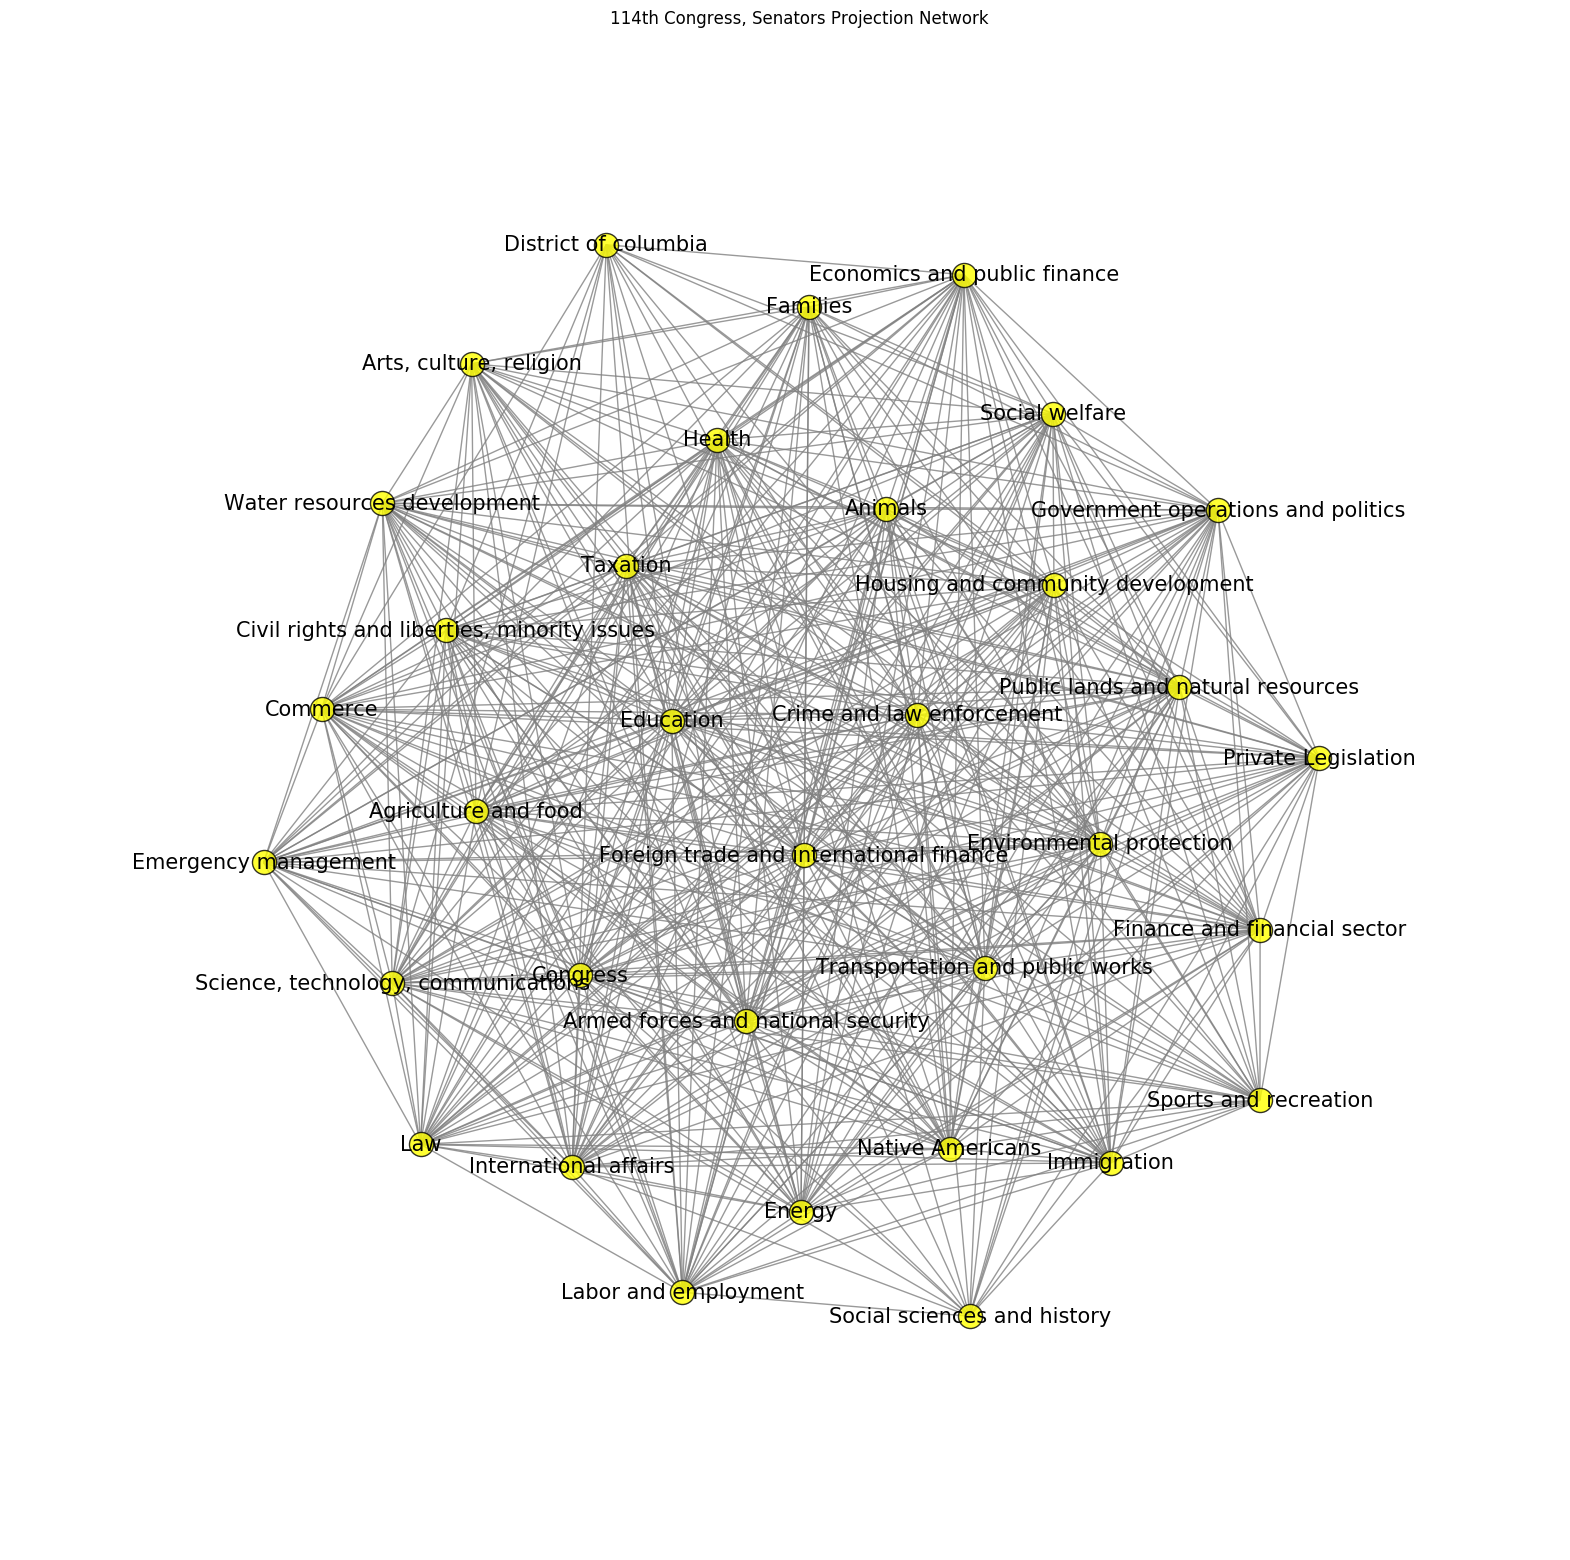

In [14]:
#Graph shows Senators are tightly connected.
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.6, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of bill subjects. 

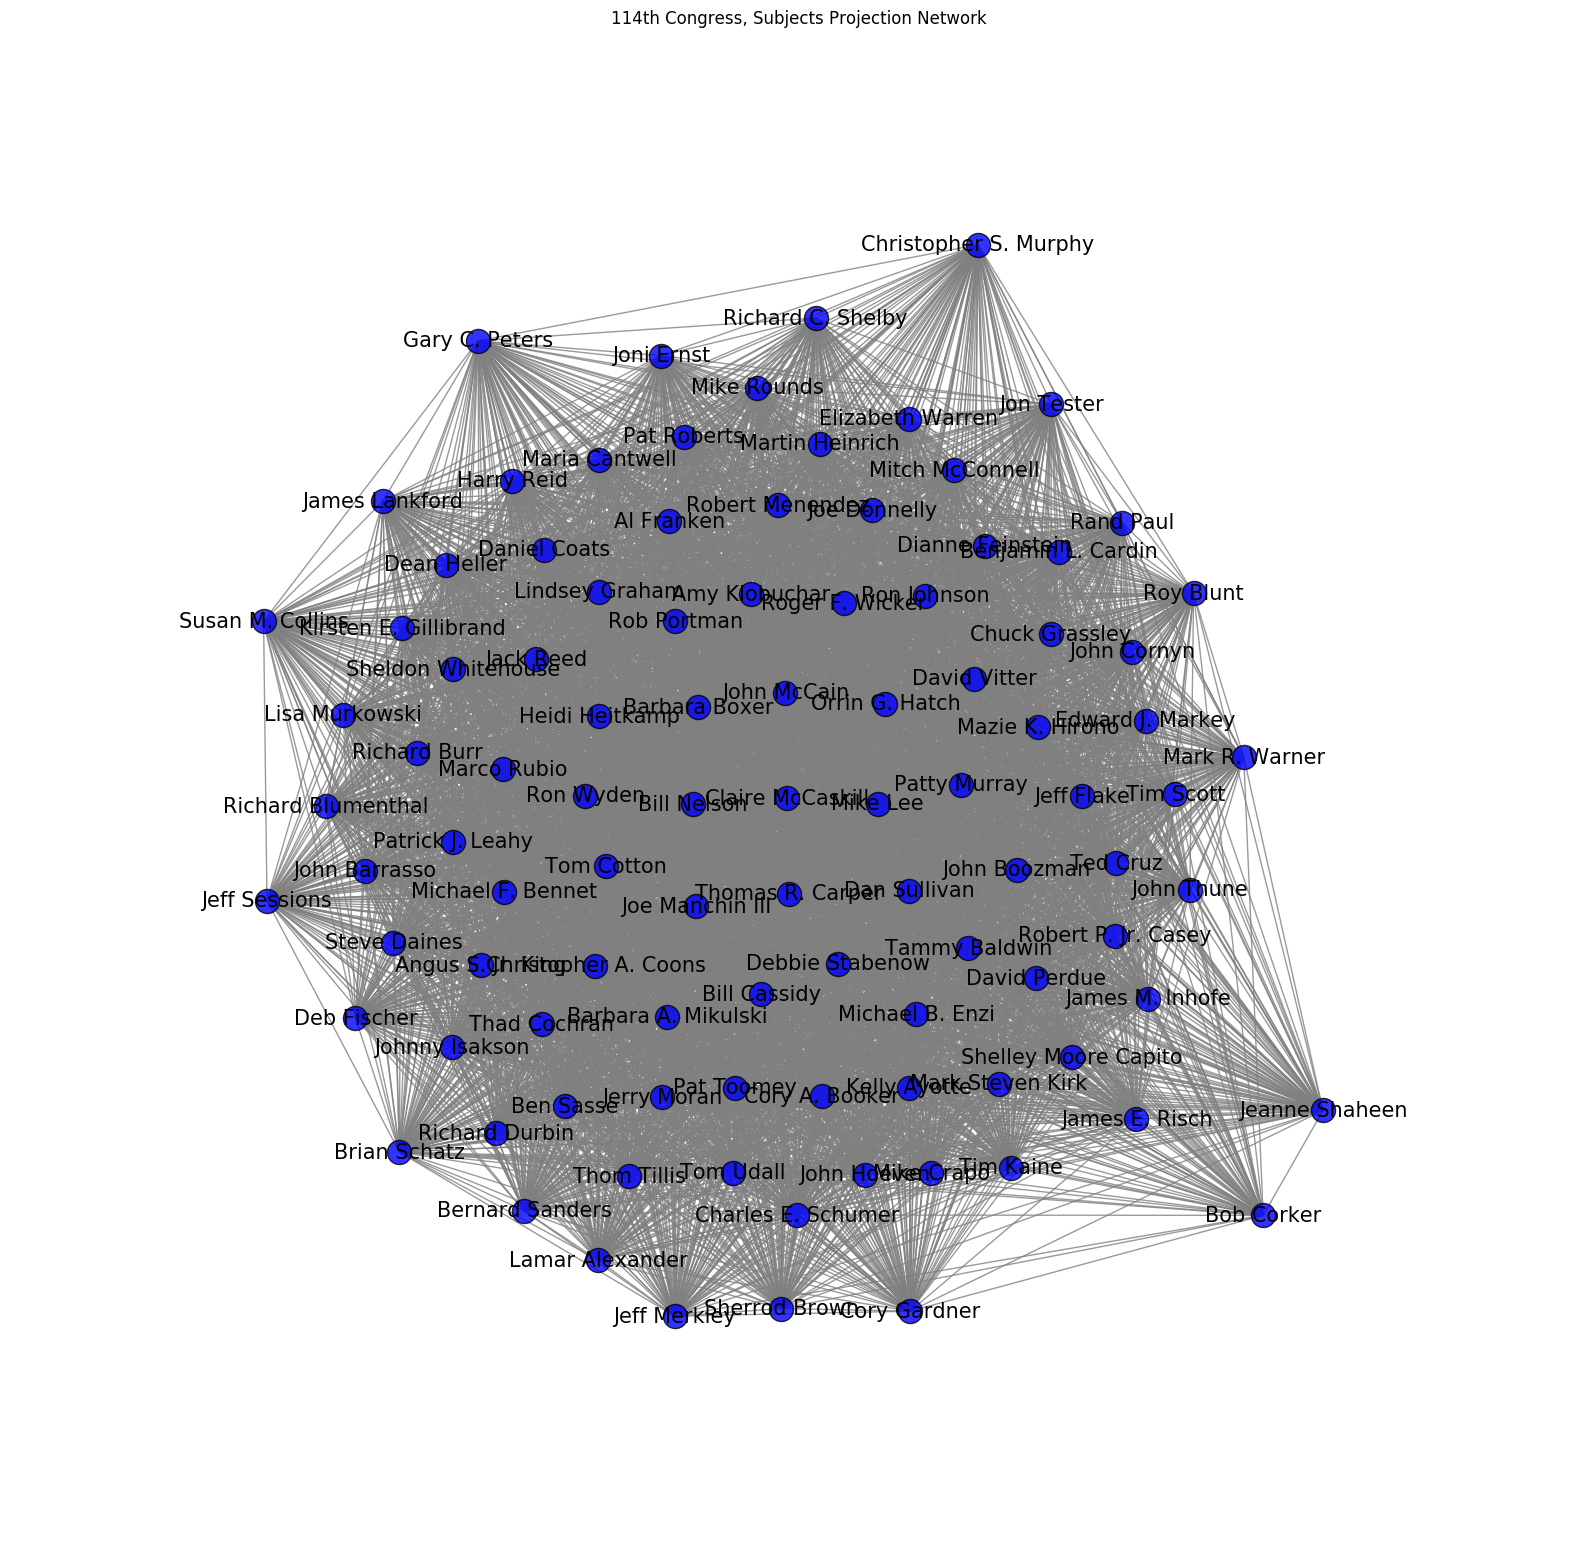

In [15]:
#Graph shows they are connected to the most part.
#Not all subjects are linked. Example: Social sciences & history and District of Columbia
#They were least popular among Senators

G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b')
plt.title('114th Congress, Subjects Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense. Output suggests it is not a dense graph.

In [16]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))

0.3720588235294118
0.3720588235294118


###Clustering

Two-mode clustering metrics show there is a high level of clustering around Senators Gary C. Peters, Senator Edward J. Markey and Senator Amy Klobuchar. In other words Senators are creating clusters around subjects. We can assume that Senators are more actively working on subjects.

In [17]:
c = bipartite.clustering(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
50                                Gary C. Peters    0.467979
102                             Edward J. Markey    0.466050
57                                 Amy Klobuchar    0.465132
0                                    Rob Portman    0.458394
54                              Mark Steven Kirk    0.457735
16                                  Patty Murray    0.449602
77                                 Tammy Baldwin    0.443799
1                                   Brian Schatz    0.443223
38                                Orrin G. Hatch    0.438549
107                                    Roy Blunt    0.433688
105                                Barbara Boxer    0.429799
106                                  Dean Heller    0.428701
133                                    Ron Wyden    0.428436
78                                  Kelly Ayotte    0.427624
33                                Richard Durbin    0.424544
82                         Kirsten E. Gillibrand    0.424226
27                                   John Cornyn    0.423339
22                                  David Vitter    0.422189
6                                 Jeanne Shaheen    0.421120
69                               Michael B. Enzi    0.416889
87                                  Bill Cassidy    0.415656
116                                 Cory Gardner    0.414451
66                                   Jerry Moran    0.406920
21                                Cory A. Booker    0.406413
26                                    John Thune    0.406024
128                              Bernard Sanders    0.404171
29                                   Marco Rubio    0.402996
71                         Christopher S. Murphy    0.402861
39                            Sheldon Whitehouse    0.398786
62                                    Jeff Flake    0.398304
..                                           ...         ...
5                                 James Lankford    0.248444
10                                    Harry Reid    0.244810
120                                 David Perdue    0.236183
119                                 Thad Cochran    0.228641
122                 Economics and public finance    0.218295
75                                Social welfare    0.214168
130                                  Immigration    0.211763
79                                           Law    0.207037
23                          Agriculture and food    0.205080
13                                James E. Risch    0.201195
109      Foreign trade and international finance    0.200920
115                                  Mike Rounds    0.189306
110                                    Ben Sasse    0.185288
18                              Native Americans    0.174577
127                  Water resources development    0.169541
34             Housing and community development    0.167055
14                                   Thom Tillis    0.165161
70                             Richard C. Shelby    0.164930
3                                  Jeff Sessions    0.153204
60                                       Animals    0.148732
95                          Emergency management    0.145375
51   Civil rights and liberties, minority issues    0.126924
129                                     Congress    0.118515
80                                      Families    0.118401
81                                    Bob Corker    0.101726
48                           Private Legislation    0.082698
83                       Arts, culture, religion    0.053245
92                         Sports and recreation    0.042717
93                   Social sciences and history    0.032616
103                         District of columbia    0.025329

[134 rows x 2 columns]

###Local clustering coefficient for two-mode networks

Clustering values obtained using *Robins Alexander method* and *Global Average Method* differ because *Robins Alexander method* clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. Robins and Alexander defined a coefficient as the ratio between the number of 4-cycles and the number of 3-paths.

Whereas *Global Average Method* uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.

Reference: https://toreopsahl.com/tnet/two-mode-networks/clustering/

In [18]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.552
0.316


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [19]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                                    node2  \
0      District of columbia                                Education   
1      District of columbia        Housing and community development   
2      District of columbia                    International affairs   
3      District of columbia                     Labor and employment   
4      District of columbia       Government operations and politics   
5      District of columbia  Foreign trade and international finance   
6      District of columbia             Economics and public finance   
7      District of columbia                 Environmental protection   
8               Rob Portman                            Sherrod Brown   
9               Rob Portman                            Sherrod Brown   
10              Rob Portman                     Shelley Moore Capito   
11              Rob Portman                              Thom Tillis   
12              Rob Portman                       Sheldon Whitehouse   
13              Rob Portman                       Sheldon Whitehouse   
14              Rob Portman                                Tom Udall   
15              Rob Portman                          Robert Menendez   
16              Rob Portman                          Robert Menendez   
17              Rob Portman                          Roger F. Wicker   
18              Rob Portman                          Roger F. Wicker   
19              Rob Portman                         Susan M. Collins   
20              Rob Portman                            Tammy Baldwin   
21              Rob Portman                            Tammy Baldwin   
22              Rob Portman                             Steve Daines   
23              Rob Portman                              Ron Johnson   
24              Rob Portman                         Thomas R. Carper   
25              Rob Portman                             Thad Cochran   
26              Rob Portman                      Robert P. Jr. Casey   
27              Rob Portman                      Robert P. Jr. Casey   
28              Rob Portman                                Roy Blunt   
29              Rob Portman                                Roy Blunt   
...                     ...                                      ...   
12902       Joe Manchin III                                Roy Blunt   
12903       Joe Manchin III                                Roy Blunt   
12904       Joe Manchin III                           Lisa Murkowski   
12905       Joe Manchin III                           Lisa Murkowski   
12906       Joe Manchin III                                Ron Wyden   
12907       Joe Manchin III                                Ron Wyden   
12908             Ron Wyden                            Sherrod Brown   
12909             Ron Wyden                            Sherrod Brown   
12910             Ron Wyden                            Sherrod Brown   
12911             Ron Wyden                     Shelley Moore Capito   
12912             Ron Wyden                              Thom Tillis   
12913             Ron Wyden                       Sheldon Whitehouse   
12914             Ron Wyden                       Sheldon Whitehouse   
12915             Ron Wyden                       Sheldon Whitehouse   
12916             Ron Wyden                       Sheldon Whitehouse   
12917             Ron Wyden                                Tom Udall   
12918             Ron Wyden                                Tom Udall   
12919             Ron Wyden                         Susan M. Collins   
12920             Ron Wyden                            Tammy Baldwin   
12921             Ron Wyden                            Tammy Baldwin   
12922             Ron Wyden                            Tammy Baldwin   
12923             Ron Wyden                             Steve Daines   
12924             Ron Wyden                             Steve Daines   
12925             Ron Wyden                         Thomas R. 

###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, bill subjects *Health* and *Taxation* ranked on the top. This explains Senator connecting to these bill subjects make a complete subgraph or a clique.

Bill subjects *Health* and *Taxation* connect more Senators, creating more cliques.

In [20]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
55                                    Health       88
8                                   Taxation       82
41        Public lands and natural resources       73
68        Government operations and politics       72
90        Armed forces and national security       71
56           Transportation and public works       61
118                Crime and law enforcement       61
7                                  Education       58
44                     International affairs       55
125             Finance and financial sector       55
94                  Environmental protection       54
101                                   Energy       51
30                                  Commerce       45
64                      Labor and employment       44
67       Science, technology, communications       42
122             Economics and public finance       36
75                            Social welfare       34
130                              Immigration       34
109  Foreign trade and international finance       32
18                          Native Americans       27
23                      Agriculture and food       27
79                                       Law       26
22                              David Vitter       23
127              Water resources development       22
34         Housing and community development       22
57                             Amy Klobuchar       21
62                                Jeff Flake       20
38                            Orrin G. Hatch       19
6                             Jeanne Shaheen       19
60                                   Animals       19
..                                       ...      ...
132                          Joe Manchin III       10
37                              Joe Donnelly       10
74                       Barbara A. Mikulski       10
36                                Al Franken       10
47                                Tom Cotton        9
42                                 Tim Kaine        9
61                           Martin Heinrich        9
59                                 Tim Scott        8
15                         Michael F. Bennet        8
52                            Lindsey Graham        8
9                            Lamar Alexander        8
2                               Daniel Coats        8
124                     Shelley Moore Capito        7
48                       Private Legislation        7
98                                Joni Ernst        7
5                             James Lankford        7
120                             David Perdue        7
119                             Thad Cochran        6
17                           Mitch McConnell        6
14                               Thom Tillis        5
115                              Mike Rounds        5
3                              Jeff Sessions        5
13                            James E. Risch        5
70                         Richard C. Shelby        4
110                                Ben Sasse        4
83                   Arts, culture, religion        4
92                     Sports and recreation        3
81                                Bob Corker        3
93               Social sciences and history        1
103                     District of columbia        1

[134 rows x 2 columns]

On a projected graph, bill subject *Transportation and public works* stand out. That means this subject is more popular among Senators.

In [21]:
G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
1               Tom Udall       15
5                Ted Cruz       15
56          Tammy Baldwin       15
52       Susan M. Collins       15
4           Sherrod Brown       15
93              Roy Blunt       15
99              Ron Wyden       15
78            Ron Johnson       15
91    Robert P. Jr. Casey       15
32        Robert Menendez       15
0             Rob Portman       15
74         Richard Durbin       15
24           Richard Burr       15
21     Richard Blumenthal       15
8               Rand Paul       15
64       Patrick J. Leahy       15
41             Pat Toomey       15
27         Orrin G. Hatch       15
34               Mike Lee       15
7              Mike Crapo       15
83        Mazie K. Hirono       15
90       Mark Steven Kirk       15
53         Mark R. Warner       15
60         Maria Cantwell       15
22            Marco Rubio       15
97         Lisa Murkowski       15
37         Lindsey Graham       15
57           Kelly Ayotte       15
35             Joni Ernst       15
17             Jon Tester       15
..                    ...      ...
68           Steve Daines       13
28     Sheldon Whitehouse       13
12           Patty Murray       13
48            Pat Roberts       13
49        Michael B. Enzi       13
43        Martin Heinrich       13
59  Kirsten E. Gillibrand       13
55           John Boozman       13
75          John Barrasso       13
98        Joe Manchin III       13
31         James Lankford       13
36         Gary C. Peters       13
30         Chuck Grassley       13
51  Christopher S. Murphy       13
94        Bernard Sanders       13
29              Tim Kaine       11
42              Tim Scott        9
10   Shelley Moore Capito        9
79              Ben Sasse        9
25        Roger F. Wicker        8
3           Jeff Sessions        8
84            Mike Rounds        7
65      Michael F. Bennet        7
70            John Hoeven        7
89            Deb Fischer        7
50      Richard C. Shelby        6
6         Lamar Alexander        5
11            Thom Tillis        4
58             Bob Corker        2
61         James E. Risch        1

[100 rows x 2 columns]

On a projected graph, following table, shows subgroups among bill subjects. That means these subjects are more popular among Senators and bills connected to these subjects tend to make it floor more often.

In [22]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1               node2                 node3
0                Rob Portman       Sherrod Brown             Tom Udall
1                Rob Portman       Sherrod Brown           Thom Tillis
2                Rob Portman       Sherrod Brown            Tom Cotton
3                Rob Portman       Sherrod Brown             Tim Scott
4                Rob Portman       Sherrod Brown          Steve Daines
5                Rob Portman       Sherrod Brown          Thad Cochran
6                Rob Portman       Sherrod Brown             Tim Kaine
7                Rob Portman       Sherrod Brown              Ted Cruz
8                Rob Portman       Sherrod Brown      Susan M. Collins
9                Rob Portman       Sherrod Brown         Tammy Baldwin
10               Rob Portman       Sherrod Brown      Thomas R. Carper
11               Rob Portman         Thom Tillis             Tom Udall
12               Rob Portman         Thom Tillis            Tom Cotton
13               Rob Portman         Thom Tillis      Thomas R. Carper
14               Rob Portman  Sheldon Whitehouse             Tom Udall
15               Rob Portman  Sheldon Whitehouse           Thom Tillis
16               Rob Portman  Sheldon Whitehouse            Tom Cotton
17               Rob Portman  Sheldon Whitehouse             Tim Scott
18               Rob Portman  Sheldon Whitehouse          Steve Daines
19               Rob Portman  Sheldon Whitehouse          Thad Cochran
20               Rob Portman  Sheldon Whitehouse         Sherrod Brown
21               Rob Portman  Sheldon Whitehouse             Tim Kaine
22               Rob Portman  Sheldon Whitehouse              Ted Cruz
23               Rob Portman  Sheldon Whitehouse      Susan M. Collins
24               Rob Portman  Sheldon Whitehouse         Tammy Baldwin
25               Rob Portman  Sheldon Whitehouse      Thomas R. Carper
26               Rob Portman  Sheldon Whitehouse  Shelley Moore Capito
27               Rob Portman           Tim Kaine             Tom Udall
28               Rob Portman           Tim Kaine            Tom Cotton
29               Rob Portman           Tim Kaine             Tim Scott
...                      ...                 ...                   ...
159012  Shelley Moore Capito    Susan M. Collins          Thad Cochran
159013  Shelley Moore Capito    Susan M. Collins             Tim Kaine
159014  Shelley Moore Capito    Susan M. Collins              Ted Cruz
159015  Shelley Moore Capito    Susan M. Collins         Tammy Baldwin
159016  Shelley Moore Capito    Susan M. Collins      Thomas R. Carper
159017  Shelley Moore Capito       Tammy Baldwin             Tom Udall
159018  Shelley Moore Capito       Tammy Baldwin            Tom Cotton
159019  Shelley Moore Capito       Tammy Baldwin             Tim Scott
159020  Shelley Moore Capito       Tammy Baldwin          Thad Cochran
159021  Shelley Moore Capito       Tammy Baldwin             Tim Kaine
159022  Shelley Moore Capito       Tammy Baldwin              Ted Cruz
159023  Shelley Moore Capito       Tammy Baldwin      Thomas R. Carper
159024  Shelley Moore Capito        Steve Daines             Tom Udall
159025  Shelley Moore Capito        Steve Daines            Tom Cotton
159026  Shelley Moore Capito        Steve Daines             Tim Scott
159027  Shelley Moore Capito        Steve Daines          Thad Cochran
159028  Shelley Moore Capito        Steve Daines             Tim Kaine
159029  Shelley Moore Capito        Steve Daines              Ted Cruz
159030  Shelley Moore Capito        Steve Daines      Susan M. Collins
159031  Shelley Moore Capito        Steve Daines         Tammy Baldwin
159032  Shelley Moore Capito        Steve Daines      Thomas R. Carper
159033  Shelley Moore Capito    Thomas R. Carper             Tom Udall
159034  Shelley Moore Capito    Thomas R. Carper            Tom Cotton
159035  Shelley Moore Capito    Thomas R. Carper             Tim Scott
159036  Shelley Moore Capito    Thomas R. Carpe

###Final Analysis

- Senators presenting most bills
- Subjects on which most bills are presented.

We will be using *island method* from chapter 4 of *Social Network Analysis for Startups*

In [23]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
        
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
cc = max(nx.connected_component_subgraphs(B), key=len)
islands=island_method(cc)

Analysis: 

- When every Senator presents one bill on any of 34 subjects; network separates into 129 nodes and 129 islands.
- When the water level is raised 6 units, meaning removing Senators from the network who present less than 6 bills, network separates into 73 nodes and 73 islands.
- When the water level is raised 11 units, meaning removing Senators from the network who present less than 11 bills, network separates into 21 nodes and 3 islands. The first island has 7 nodes, the second island has 6 nodes and third has 8 nodes.
- When the water level is raised 21 units, meaning removing Senators from the network who present less than 21 bills, network separates into 4 nodes and 2 islands. Both islands have 2 nodes each.
- When the water level is raised the highest possible level, meaning removing Senators from the network who present less than 26 bills, network separates into 2 nodes and single island. This combination represents Senator presenting most bills and popular subject.


In [24]:
print ('%-25s %-45s %-13s' % ('Number of Bills', 'Nodes(Senetors + Subjects)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))

Number of Bills           Nodes(Senetors + Subjects)                    Islands      
1                         129                                           [129]        
6                         73                                            [73]         
11                        21                                            [7, 8, 6]    
16                        8                                             [3, 2, 3]    
21                        4                                             [2, 2]       
26                        2                                             [2]          


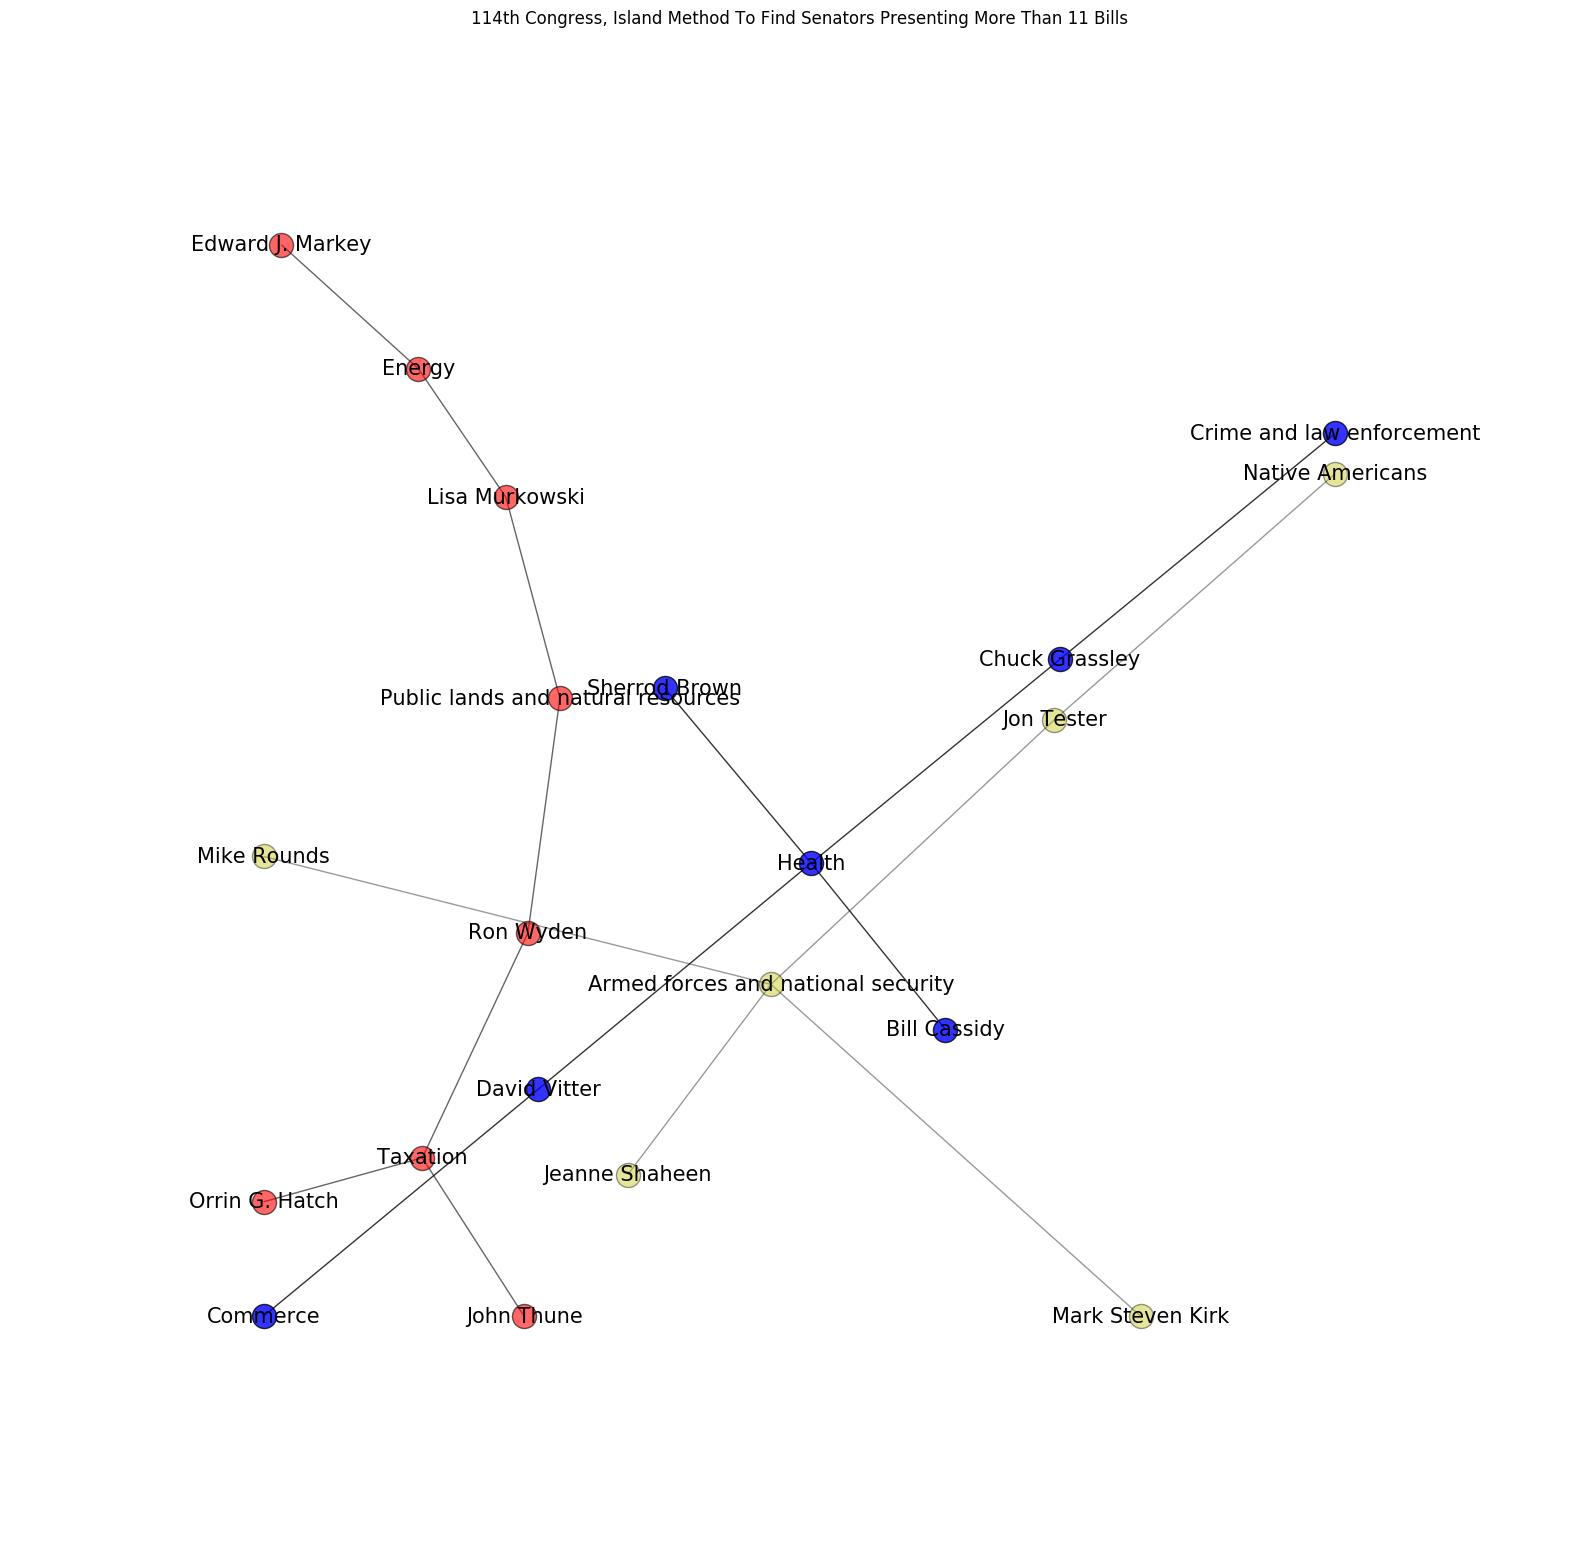

In [25]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 11:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('114th Congress, Island Method To Find Senators Presenting More Than 11 Bills')
plt.show()


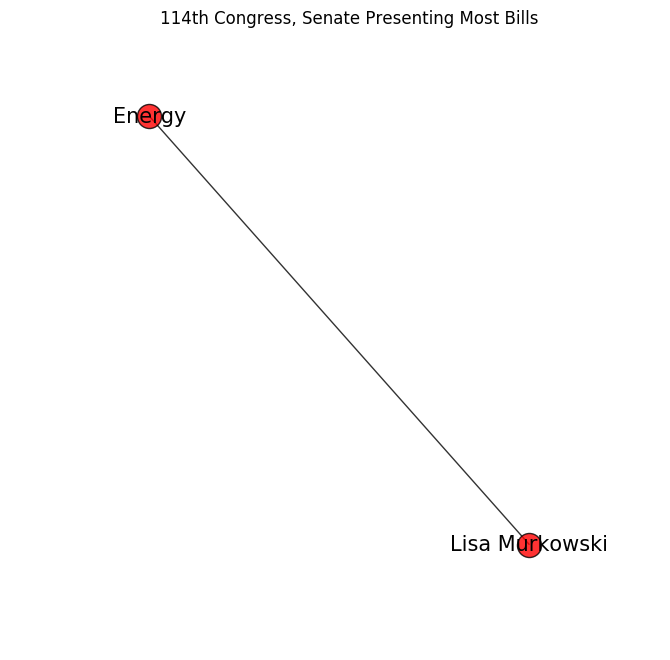

In [26]:
#Senetor presenting most bills on popular subject
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(6, 6))

for i in islands:
    if i[0] == 26:
        for c in nx.connected_component_subgraphs(i[1]):
            nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'r')
            
plt.title('114th Congress, Senate Presenting Most Bills')
plt.show()